<a href="https://colab.research.google.com/github/shepai/BIORTC_Nigeria/blob/main/Workshops/rnn_rdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

Training RNN on the delayed random dot motion task (DRDM)
==================================



## Settings



In [1]:
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rc("axes.spines", top=False, right=False)

golden_ratio = (5**.5 - 1) / 2
width = 5
height = width * golden_ratio

plt.rc("axes.spines", top=False, right=False)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams["figure.autolayout"] = True
plt.rcParams['lines.markersize'] = 5
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

## Imports



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

For reproducibility we fix the random seeds

In [3]:
torch.manual_seed(23)
np.random.seed(23)

## 🧠 Dynamical RNNs



Let:
-   $ h^{ext}(t) $: a varying feedforward input at time step $ t $ from the input neurons
-   $ h^{ext}_0(t) $: a constant feedforward input from an outside area
-   $ r(t) $: the rate of the recurrent neurons at time $ t $
-   $ h^{out}_0 $: a constant output from an outside area
-   $ y(t) $: output at time $ t $

We have the following differential equation
$$
\tau \frac{dr}{dt}(t) = -r(t) + \mathcal{F}(W_{ext} h^{ext}(t) + h^{ext}_0 + W_{rec} r(t))
$$
We discretize it using an Euler-Murayam scheme
$$
\tau \frac{r(t + \delta t) -r(t)}{\delta t} = -r(t) + \mathcal{F}(W_{ext} h^{ext}(t) + h^{ext}_0 + W_{rec} r(t))
$$

This gives us a relation between $r(t)$ and $r(t + \delta t)$ where $\delta t$ is small

$$
r(t + \delta t) = (1 - \frac{\delta t}{\tau}) r(t) + \frac{\delta t}{\tau} \mathcal{F}(W_{ext} h^{ext}(t) + h^{ext}_0 + W_{rec} r(t))
$$

Starting from a given initializaton at $t=t_0$,

we compute $r(t_1)$ and $h^{ext}(t_1)$ from $r(t_0)$ and $h^{ext}(t_0)$,

then $r(t_2)$ and $h^{ext}(t_2)$ from $r(t_1)$ and $h^{ext}(t_1)$,

...

then $r(t_n)$ and $h^{ext}(t_n)$ from $r(t_{n-1})$ and $h^{ext}(t_{n-1})$,


and iterate until the end of the sequence.

So that in the end we get a readout of the network at each timepoint
$$
y(t) = \mathcal{S}(W_{out} r(t) + h^{out}_0)
$$

In [4]:
class BioRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dt=0.1, tau=1.0, sigma=0.1):
        super().__init__()
        # input layer
        self.wi = nn.Linear(input_size, hidden_size)
        # recurrent layer
        self.wrec = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        # we initialize the recurrent weights with xavier initialization
        nn.init.xavier_uniform_(self.wrec)
        # output layer
        self.wo = nn.Linear(hidden_size, output_size)
        # non linearity
        self.nonlinearity = torch.tanh
        # time constant
        self.DT_TAU = torch.tensor(dt / tau)
        # variance of the noise
        self.sigma = sigma
        self.scale = torch.sqrt(self.DT_TAU)

    def update_dynamics(self, ff_inputs, rates):
        '''
        :param ff_inputs: float, tensor of size (n_trials, hidden_size)
        :param rates: float, tensor of size (n_trials, hidden_size)
        This function computes the rates at time t+1 from time t
        based on the discretized dynamics of the neurons
        from the Euler-Murayama scheme
        '''
        rec_inputs = rates @ self.wrec.T
        nonlinear = self.nonlinearity(self.wi(ff_inputs) + rec_inputs)
        rates = (1-self.DT_TAU) * rates + self.DT_TAU * nonlinear

        return rates


    def forward(self, ff_inputs):
        '''
        :param ff_input: float, tensor of size (n_trials, seq_len, input_size)
        :return readout_list: float, tensor of size (n_trials, seq_len, output_size)
        This is the main function of the class
        the one that will be called if you call the class as a function
        '''
        n_trials, seq_len, input_size = ff_inputs.shape
        hidden_size = self.wrec.shape[0]

        noise = self.scale * self.sigma * torch.randn(n_trials, seq_len, hidden_size)
        rates = torch.randn(n_trials, hidden_size)

        readout_list = []
        # for each step in the sequence we update the dynamics
        for step in range(seq_len):
            # we compute the rates
            rates = self.update_dynamics(ff_inputs[:, step], rates)
            rates += noise[:, step]
            # compute the output
            readout = self.wo(rates)
            # and save the output
            readout_list.append(readout)

        readout_list = torch.stack(readout_list, dim=1)

        return readout_list

---



## Initializing the model



In [5]:
input_size = 1
hidden_size = 256
output_size = 1

model = BioRNNModel(input_size, hidden_size, output_size)

## The random dot motion task



We need to set times for the task parameters

In [6]:
DT = 0.1 # in second

fixation_onset = 0
fixation_offset = int(0.5 / DT)

stim_onset = int(1 / DT)
stim_offset = int(2 / DT)

response_onset = int(3 / DT)
seq_len = int(4 / DT)

x_time = np.linspace(0, 4, seq_len)

and we need to choose the coherences

In [7]:
coherence_list=np.linspace(-5, 5, 20)
print(coherence_list)

[-5.         -4.47368421 -3.94736842 -3.42105263 -2.89473684 -2.36842105
 -1.84210526 -1.31578947 -0.78947368 -0.26315789  0.26315789  0.78947368
  1.31578947  1.84210526  2.36842105  2.89473684  3.42105263  3.94736842
  4.47368421  5.        ]


### A random dot motion task



#### Solution



In [8]:
def generate_rdm_trials(n_trials, seq_len, input_size, coherence_list=np.linspace(-5, 5, 20), noise=.1):
    '''
    :param n_trials: int
    :param coherences: list of coherence values
    :return: inputs, targets, mask and coherence
   '''

    coherence_list = torch.tensor(coherence_list)

    # inputs, targets and mask
    inputs = noise * torch.randn((n_trials, seq_len, input_size))
    targets = torch.zeros((n_trials, seq_len))
    mask = torch.zeros((1, seq_len))

    # randomizing coherence across trials
    idx_coherence = torch.randint(0, len(coherence_list), size=(n_trials, 1))
    coherence = coherence_list[idx_coherence]

    # add coherence to the inputs
    inputs[:, stim_onset:stim_offset] += coherence.unsqueeze(-1) * noise

    # setting target upon coherence sign
    targets[:, response_onset:] = 1.0 * (coherence>0) - 1.0 * (coherence<=0)

    # setting response window
    mask[:, response_onset:] = 1

    return inputs, targets, mask, coherence

### Visualization



In [9]:
n_trials = 512
inputs, targets, mask, coherence = generate_rdm_trials(n_trials, seq_len, input_size, coherence_list)
print(inputs.shape, targets.shape, mask.shape, coherence.shape)

torch.Size([512, 40, 1]) torch.Size([512, 40]) torch.Size([1, 40]) torch.Size([512, 1])


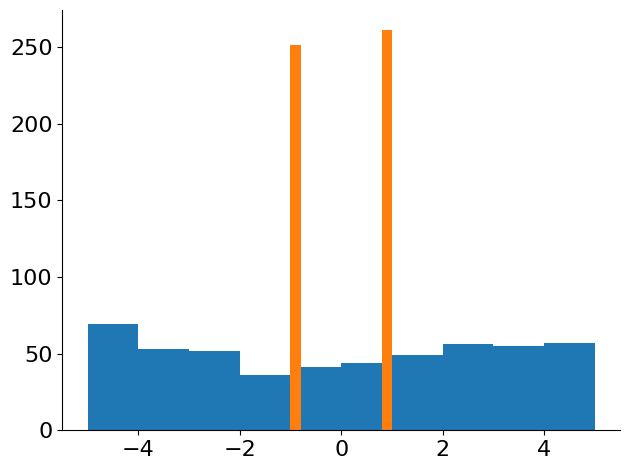

In [10]:
plt.hist(coherence[:, 0])
plt.hist(targets[:, -1])
plt.show()

In [11]:
idx_left = torch.argwhere(targets[:, -1] == -1).reshape(-1)[:32]
idx_right = torch.argwhere(targets[:, -1] == 1).reshape(-1)[:32]
print(idx_right.shape, idx_left.shape)

torch.Size([32]) torch.Size([32])


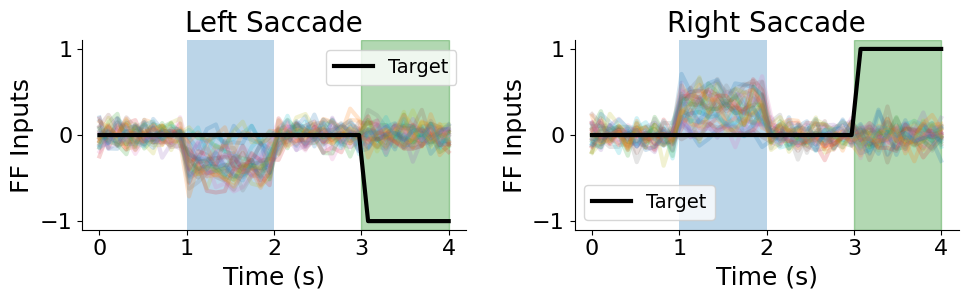

In [12]:
fig , ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(x_time, inputs[idx_left, :, 0].mT.cpu().numpy(), alpha=.2)
ax[0].plot(x_time, targets[idx_left[0]].cpu().numpy(), 'k', label='Target')
ax[0].set_title('Left Saccade')

ax[1].plot(x_time, inputs[idx_right, :, 0].mT.cpu().numpy(), alpha=.2)
ax[1].plot(x_time, targets[idx_right[0]].cpu().numpy(), 'k', label='Target')
ax[1].set_title('Right Saccade')

for i in range(2):
    ax[i].axvspan(stim_onset * DT, stim_offset * DT, alpha=0.3)
    ax[i].axvspan(response_onset * DT, seq_len * DT, alpha=0.3, color='g')
    ax[i].set_ylim([-1.1, 1.1])
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('FF Inputs')
    ax[i].legend(fontsize=14)
plt.show()


Testing the naive network



In [13]:
predictions = model(inputs).squeeze((-1)).detach().cpu()
print('inputs', inputs.shape, 'predictions', predictions.shape)

inputs torch.Size([512, 40, 1]) predictions torch.Size([512, 40])


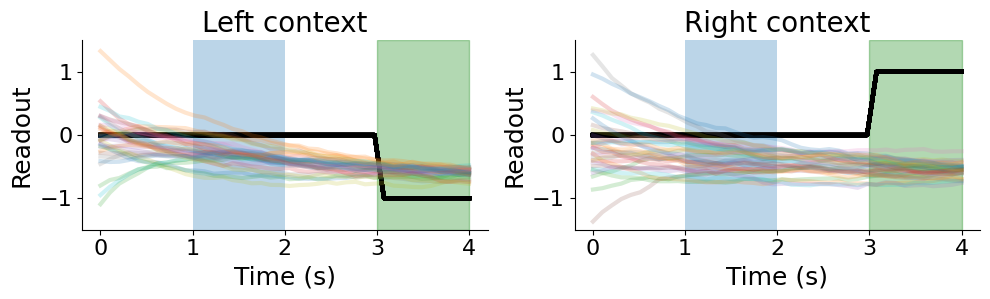

In [14]:
fig , ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(x_time, targets[idx_left].T, 'k')
ax[0].plot(x_time, predictions[idx_left].T, alpha=.2)
ax[0].set_title('Left context')

ax[1].plot(x_time, targets[idx_right].T, 'k')
ax[1].plot(x_time, predictions[idx_right].T, alpha=.2)
ax[1].set_title('Right context')

for i in range(2):
    ax[i].axvspan(stim_onset * DT, stim_offset * DT, alpha=0.3)
    ax[i].axvspan(response_onset * DT, seq_len * DT, alpha=0.3, color='g')
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Readout")
    ax[i].set_ylim([-1.5, 1.5])
    # ax[i].legend(fontsize=14)

plt.show()

## Training the model



Let's choose the optimization parameters

In [15]:
learning_rate = 0.1
epochs = 100
batch_size = 32

Let's write the optimization loop

In [16]:
from torch.utils.data import DataLoader, TensorDataset

def optimization(model, X, Y, criterion, optimizer, mask=1, epochs=30, batch_size=32, bl=stim_offset, verbose=1):
    # make the data a tensor dataset
    dataset = TensorDataset(X, Y)
    # DataLoader generates batches and shuffles the data
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    loss_list = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in loader:

            output = model(batch_x).squeeze(-1)
            # we compute errors in the response window
            loss = criterion(output, batch_y) * mask
            loss = torch.mean(loss)

            # we impose zero readout outside the response window
            loss_bl = criterion(output[:, :bl], batch_y[:, :bl]*0) * (1-mask[:, :bl])
            loss += torch.mean(loss_bl)

            # backpropagation
            loss.backward()
            # updating the weights
            optimizer.step()
            # resetting the weights for the next pass
            optimizer.zero_grad()

            total_loss += loss.item()

        loss_list.append(total_loss)

        if (verbose) and (((epoch+1) % 5==0) or (epoch==epochs-1) or (epoch==0)):
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss:.4f}')

    return loss_list

Now we choose a loss, an optimizer and run the optimization

In [17]:
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = optimization(model, inputs, targets, criterion, optimizer, mask, epochs)

Epoch 1/100, Training Loss: 2.0609
Epoch 5/100, Training Loss: 0.7880
Epoch 10/100, Training Loss: 0.4179
Epoch 15/100, Training Loss: 0.3199
Epoch 20/100, Training Loss: 0.3669
Epoch 25/100, Training Loss: 0.3066
Epoch 30/100, Training Loss: 0.3097
Epoch 35/100, Training Loss: 0.2932
Epoch 40/100, Training Loss: 0.3024
Epoch 45/100, Training Loss: 0.2526
Epoch 50/100, Training Loss: 0.1900
Epoch 55/100, Training Loss: 0.1484
Epoch 60/100, Training Loss: 0.1496
Epoch 65/100, Training Loss: 0.1145
Epoch 70/100, Training Loss: 0.1093
Epoch 75/100, Training Loss: 0.0783
Epoch 80/100, Training Loss: 0.1080
Epoch 85/100, Training Loss: 0.0621
Epoch 90/100, Training Loss: 0.0928
Epoch 95/100, Training Loss: 0.0917
Epoch 100/100, Training Loss: 0.0876


## Testing the model



In [18]:
inputs, targets, mask, coherence = generate_rdm_trials(n_trials, seq_len, input_size)
predictions = model(inputs).squeeze((-1)).detach().cpu()
print('inputs', inputs.shape, 'predictions', predictions.shape)

inputs torch.Size([512, 40, 1]) predictions torch.Size([512, 40])


In [19]:
idx_left = torch.argwhere(targets[:, -1] == -1).reshape(-1)
idx_right = torch.argwhere(targets[:, -1] == 1).reshape(-1)
print(idx_right.shape, idx_left.shape)

torch.Size([260]) torch.Size([252])


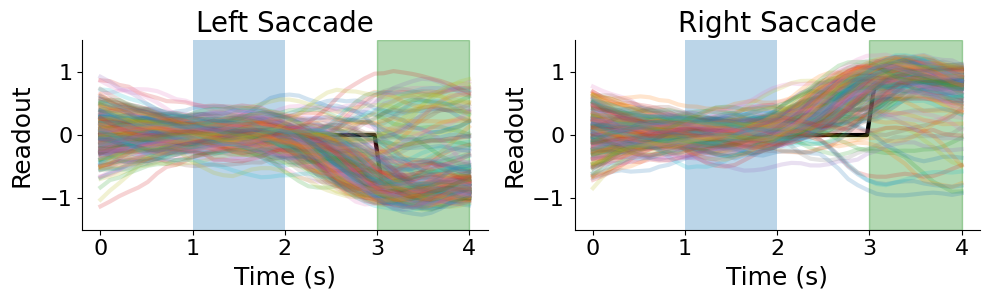

In [20]:
fig , ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(x_time, targets[idx_left[0]], 'k', label='Target')
ax[0].plot(x_time, predictions[idx_left].T, alpha=.2)
ax[0].set_title('Left Saccade')

ax[1].plot(x_time, targets[idx_right[0]], 'k', label='Target')
ax[1].plot(x_time, predictions[idx_right].T, alpha=.2)
ax[1].set_title('Right Saccade')

for i in range(2):
    ax[i].axvspan(stim_onset * DT, stim_offset * DT, alpha=0.3)
    ax[i].axvspan(response_onset * DT, seq_len * DT, alpha=0.3, color='g')
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Readout")
    ax[i].set_ylim([-1.5, 1.5])
    # ax[i].legend(fontsize=14)

plt.show()

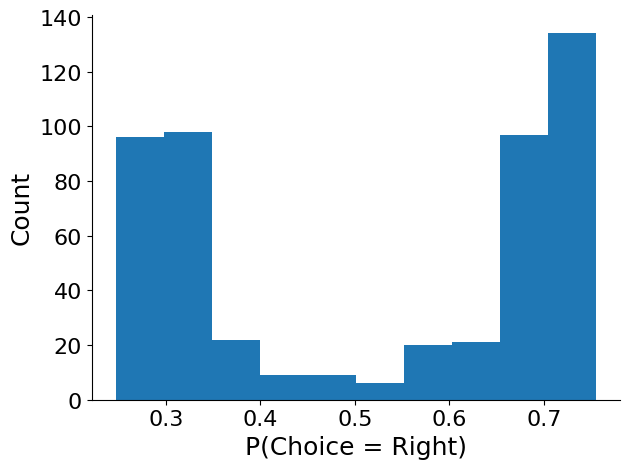

In [21]:
prob = torch.sigmoid(predictions[:, -1])
idx = torch.where(targets[:, -1]==1)

plt.hist(prob.cpu())
plt.xlabel('P(Choice = Right)')
plt.ylabel('Count')
plt.show()

Now we can look at the behavior of the network

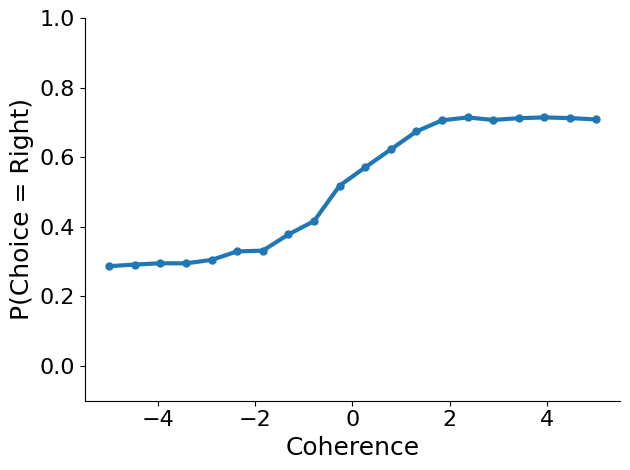

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming prob and coherences defined as above
bins = np.sort(np.unique(coherence[:,0]))
psychometric = [prob[coherence[:, 0] == c].mean().item() for c in bins]

plt.plot(bins, psychometric, 'o-')
plt.xlabel('Coherence')
plt.ylabel('P(Choice = Right)')
plt.ylim([-0.1, 1])
plt.show()